# Apartment Machine Learning Project

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [3]:
pd.options.display.float_format = '{:,.1f}'.format

In [4]:
def read_csv(file_name):
    return pd.read_csv(file_name)

# Data Cleaning

## Yad2.co.il Data
Inorder to acquire larger amount of data, we used 2 data source. In this section we will only handle the Yad2.co.il data, which we scrapped using our selenium crawler.
We will first load the CSV file into a Data Frame and take a quick look at it.

In [5]:
yad2_df = read_csv('raw_yad2_data.csv')
yad2_df.head()

,Post link,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,dks8vn48,חדרה,גבעת אולגה,127,4.0,5.0,980.0,"4,700.0",1,1,1,1,1,1.0,1,1,1,1,1,1
1,jmjfaz37,חיפה,"יל""ג",65,3.5,1.0,NaN,"2,400.0",1,1,1,1,0,NaN,1,1,1,1,1,1
2,iphkc13r,רמות ספיר,"שכונה י""א",70,3.0,1.0,400.0,"2,450.0",1,1,1,1,1,NaN,1,1,1,1,1,1
3,9chmff31,קרית אתא,מרכז העיר,70,3.0,1.0,500.0,"2,900.0",1,1,1,1,0,NaN,1,1,1,1,1,1
4,yp7la93q,מגדל העמק,רמת בלפור,80,3.5,3.0,512.0,"2,095.0",1,1,1,1,1,NaN,1,1,1,1,1,1


In [6]:
yad2_df.shape

(9110, 20)

#### Removing duplicates
We used the 'Post link' feature as a unique identifier for each entry. The 'Post link' is the suffix of the URL which is used to identify each post. For example, a link to a post will look like: "https://www.yad2.co.il/item/x29qkv38", so it's 'Post link' will be "x29qkv38".
We can see that we had about 3000 duplicates, this is because the crawler sometimes would fail, or get blocked by the server, so it will try to get the whole page again and this would create many duplicates.

In [7]:
yad2_df.drop_duplicates(['Post link'], inplace=True)
yad2_df.shape

(6650, 20)

#### Handling null values
The 'Price' and 'Number of rooms' are 2 key features in our data set. Because of that, we decided to drop entries that had that value missing.
As we can see, we will only lose about 200 entries, which is not much.

In [8]:
yad2_df.dropna(subset=['Price', 'Number of rooms'], inplace=True)
yad2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6344 entries, 0 to 9109
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Post link        6344 non-null   object 
 1   City             6344 non-null   object 
 2   Neighborhood     6344 non-null   object 
 3   Size             6344 non-null   int64  
 4   Number of rooms  6344 non-null   float64
 5   Floor number     5960 non-null   float64
 6   Taxes            2866 non-null   float64
 7   Price            6344 non-null   float64
 8   Room mates       6344 non-null   int64  
 9   Furniture        6344 non-null   int64  
 10  Elevator         6344 non-null   int64  
 11  Air conditioner  6344 non-null   int64  
 12  Parking          6344 non-null   int64  
 13  Balcony          2871 non-null   float64
 14  Bars             6344 non-null   int64  
 15  Shelter          6344 non-null   int64  
 16  Storeroom        6344 non-null   int64  
 17  Renovated     

We chose to fill in the missing values in some features.
The missing values of the 'Balcony' feature is due to fact that some posts were missing that value, so we took an assumption that if an apartment would have a balcony, the owner would have mentioned it in the post, and if he didn't, that is probably because there is no balcony.

To fill the missing values of the 'Floor number' feature we chose to use median, because it gives less weigh to edge values. Meaning that if we had an entry with 'Floor number' of 100, it wouldn't affect as much on the median as it would affect the average.

In [9]:
yad2_df['Floor number'].fillna(value=yad2_df['Floor number'].median(), inplace=True)
yad2_df['Balcony'].fillna(value=0, inplace=True)
yad2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6344 entries, 0 to 9109
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Post link        6344 non-null   object 
 1   City             6344 non-null   object 
 2   Neighborhood     6344 non-null   object 
 3   Size             6344 non-null   int64  
 4   Number of rooms  6344 non-null   float64
 5   Floor number     6344 non-null   float64
 6   Taxes            2866 non-null   float64
 7   Price            6344 non-null   float64
 8   Room mates       6344 non-null   int64  
 9   Furniture        6344 non-null   int64  
 10  Elevator         6344 non-null   int64  
 11  Air conditioner  6344 non-null   int64  
 12  Parking          6344 non-null   int64  
 13  Balcony          6344 non-null   float64
 14  Bars             6344 non-null   int64  
 15  Shelter          6344 non-null   int64  
 16  Storeroom        6344 non-null   int64  
 17  Renovated     

#### Removing unnecessary features

In [10]:
yad2_df.drop(['Post link', 'Taxes'], axis=1, inplace=True)

## Homeless.co.il Data
We will follow the same procedure as before for the Homeless data set.
We loaded the CSV and took a look at a few entries.

In [11]:
homeless_df = read_csv('raw_homeless_data.csv')
homeless_df.head()

,Page number,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,685019,חיפה,נוה שאנן,80.0,3.0,3.0,1150,"3,400.0",0,1,0,1,0,0,0,0,0,1,1,0
1,685018,חיפה,נווה שאנן,35.0,1.0,1.0,280,"1,950.0",0,1,0,1,0,0,1,0,0,1,1,0
2,685017,פוריה כפר עבודה,החרוב,90.0,3.0,0.0,0,"3,800.0",0,0,0,1,1,1,0,0,0,1,0,0
3,685016,פוריה כפר עבודה,החרוב,90.0,3.0,0.0,0,"3,800.0",0,0,0,1,1,1,0,0,0,1,0,0
4,685015,תל אביב יפו,גימל החדשה,86.0,3.0,1.0,1180,"11,000.0",0,1,1,1,1,1,0,1,0,1,0,1


In [12]:
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4515 non-null   int64  
 1   City             4514 non-null   object 
 2   Neighborhood     4515 non-null   object 
 3   Size             4478 non-null   float64
 4   Number of rooms  4468 non-null   float64
 5   Floor number     4504 non-null   float64
 6   Taxes            4515 non-null   int64  
 7   Price            4469 non-null   float64
 8   Room mates       4515 non-null   int64  
 9   Furniture        4515 non-null   int64  
 10  Elevator         4515 non-null   int64  
 11  Air conditioner  4515 non-null   int64  
 12  Parking          4515 non-null   int64  
 13  Balcony          4515 non-null   int64  
 14  Bars             4515 non-null   int64  
 15  Shelter          4515 non-null   int64  
 16  Storeroom        4515 non-null   int64  
 17  Renovated     

In [13]:
homeless_df.describe(include='all')

,Page number,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
count,"4,515.0",4514,4515,"4,478.0","4,468.0","4,504.0","4,515.0","4,469.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0","4,515.0"
unique,NaN,302,1359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,תל אביב יפו,מרכז,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,535,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"680,875.1",NaN,NaN,"2,775,611.6",8.7,2.1,495.2,"4,395.4",0.3,0.5,0.3,0.9,0.7,0.5,0.3,0.1,0.1,0.3,0.3,0.1
std,"4,012.7",NaN,NaN,"184,427,889.9",12.0,1.9,"3,235.3","4,142.2",0.4,0.5,0.5,0.2,0.5,0.5,0.5,0.3,0.3,0.4,0.5,0.3
min,"665,030.0",NaN,NaN,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,"680,228.5",NaN,NaN,60.0,3.0,1.0,0.0,"2,900.0",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,"681,754.0",NaN,NaN,75.0,3.0,2.0,200.0,"3,800.0",0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,"683,507.0",NaN,NaN,98.0,5.0,3.0,620.0,"4,950.0",1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


#### Removing duplicates
As before, we used the 'Page number' as a unique identifier for each entry. This feature holds the number of the post that is listed at Homeless. If we have a post with the following link: "https://www.homeless.co.il/rent/viewad,685021", it's post number would be "685021".
This time, we only had 1 duplicate to remove.

In [14]:
homeless_df.drop_duplicates(['Page number'], inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514 entries, 0 to 4514
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4514 non-null   int64  
 1   City             4513 non-null   object 
 2   Neighborhood     4514 non-null   object 
 3   Size             4477 non-null   float64
 4   Number of rooms  4467 non-null   float64
 5   Floor number     4503 non-null   float64
 6   Taxes            4514 non-null   int64  
 7   Price            4468 non-null   float64
 8   Room mates       4514 non-null   int64  
 9   Furniture        4514 non-null   int64  
 10  Elevator         4514 non-null   int64  
 11  Air conditioner  4514 non-null   int64  
 12  Parking          4514 non-null   int64  
 13  Balcony          4514 non-null   int64  
 14  Bars             4514 non-null   int64  
 15  Shelter          4514 non-null   int64  
 16  Storeroom        4514 non-null   int64  
 17  Renovated     

#### Handling null values
We chose to drop entries that were missing critical features.
the amount of the data we lost was pretty small (150~) so it's not that bad.

In [15]:
homeless_df.dropna(subset=['Price', 'City', 'Number of rooms', 'Size'], inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395 entries, 0 to 4514
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4395 non-null   int64  
 1   City             4395 non-null   object 
 2   Neighborhood     4395 non-null   object 
 3   Size             4395 non-null   float64
 4   Number of rooms  4395 non-null   float64
 5   Floor number     4386 non-null   float64
 6   Taxes            4395 non-null   int64  
 7   Price            4395 non-null   float64
 8   Room mates       4395 non-null   int64  
 9   Furniture        4395 non-null   int64  
 10  Elevator         4395 non-null   int64  
 11  Air conditioner  4395 non-null   int64  
 12  Parking          4395 non-null   int64  
 13  Balcony          4395 non-null   int64  
 14  Bars             4395 non-null   int64  
 15  Shelter          4395 non-null   int64  
 16  Storeroom        4395 non-null   int64  
 17  Renovated     

To handle the null values for the 'Floor number' feature, we used median. Same as we did for the Yad2 data set

In [16]:
homeless_df['Floor number'].fillna(value=homeless_df['Floor number'].median(), inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395 entries, 0 to 4514
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4395 non-null   int64  
 1   City             4395 non-null   object 
 2   Neighborhood     4395 non-null   object 
 3   Size             4395 non-null   float64
 4   Number of rooms  4395 non-null   float64
 5   Floor number     4395 non-null   float64
 6   Taxes            4395 non-null   int64  
 7   Price            4395 non-null   float64
 8   Room mates       4395 non-null   int64  
 9   Furniture        4395 non-null   int64  
 10  Elevator         4395 non-null   int64  
 11  Air conditioner  4395 non-null   int64  
 12  Parking          4395 non-null   int64  
 13  Balcony          4395 non-null   int64  
 14  Bars             4395 non-null   int64  
 15  Shelter          4395 non-null   int64  
 16  Storeroom        4395 non-null   int64  
 17  Renovated     

#### Removing unnecessary features

In [17]:
homeless_df.drop(['Page number', 'Taxes'], axis=1, inplace=True)

# Concatenating the data frames
Now that we cleaned both the Yad2 and Homeless data frames, we can merge them and manipulate them as one data frame.
We can see that we got a total of around 10,000 entries and more than 160,000 pieces of data.

In [18]:
df = pd.concat([yad2_df, homeless_df], ignore_index=True, sort=False)
df.shape

(10739, 18)

#### Handle mis-matches in the 2 data sets
We noticed a few mismatches between the 2 data sets in string fields. For example, in Yad2 the value for Tel-Aviv could be "תל-אביב" and in Homeless it could be "תל אביב". We would like to map those 2 different values into 1. This issue had required alot of manual work.
Check the output below to see the issue with the 'City' feature.

In [19]:
df['City'].value_counts()

חיפה            1057
תל אביב יפו      704
באר שבע          684
ירושלים          578
בת ים            566
                ... 
הגולף              1
תל א               1
יד נתן             1
מושב נס הרים       1
יפו                1
Name: City, Length: 442, dtype: int64

In [20]:
df.loc[df['City'].isin(['Bat Yam', 'בת יים', 'נבת ים', 'בת ים','רמת יוסף','פארק הים','קוממיות']), 'City'] = 'בת ים'
df.loc[df['City'].isin(['ראשון', 'ראשוון לציון', 'ראשוןון לציון', 'ראשל"צ', 'ראשון לציון','ראשו','ראשון לציון מערב','מערב ותיק']), 'City'] = 'ראשון לציון'
df.loc[df['City'].isin(['פתח תקווה', 'פתח תקוה', 'G פתח תקווה','פתח תקווה','פתח ','פתח תקווהתקווה']), 'City'] = 'פתח תקווה'
df.loc[df['City'].isin(['נהריה', 'נהרייה','רסקו']), 'City'] = 'נהרייה'
df.loc[df['City'].isin(['תל-אביב', 'תל אביב יפו', 'תל אביב', 'תל אביב', '⁹תל אביב יפו', 'תל אביב טופ דן', 'תל א', 'שרונה', 'המושבה האמריקאית-גרמנית','פארק צמרת','נווה שרת','שיכוני חסכון','שכונת דן','שרונה','רמת אביב','רמת אביב ג','רמת אביב החדשה','צפון תל אביב הישן','כוכב הצפון','יפו ג','אזור המלאכה יפו','יפו ד.','גבעת העליה','גימל החדשה','נוה ברבור','הארגזים','גבעת התמרים','גבעת העליה']), 'City'] = 'תל אביב'
df.loc[df['City'].isin(['ירשלים', 'ירושלים טלביה', 'ירושלים', 'ירושליים','ירושלים פסגת זאב מזרח','קרית הממשלה','פיסגת זאב', 'פסגת זאב', 'פיסגתזאב','קרית יובל ירושלים','תלפיות מזרח','הגבעה הצרפתית',' בית יעקב','הר חומה']), 'City'] = 'ירושלים'
df.loc[df['City'].isin(['טירת הכרמל', 'טירת כרמ', 'טירת כרמלכרמל', 'טירת כרמל']), 'City'] = 'טירת כרמל'
df.loc[df['City'].isin(['רמת גן','ררמת גן','רמת גןנגבהמ','רמת גן ','G רמת גן','רמתגן','רמת יצחק',"מרכז העיר ג'",'מרכז העיר א','מרכז העיר ב','מרכז העיר']), 'City'] = 'רמת גן'
df.loc[df['City'].isin(['יוקינעם','יוקנעם','יקנעם עילית']), 'City'] = 'יקנעם'
df.loc[df['City'].isin(['גבעתיים','גבעתיים ']), 'City'] = 'גבעתיים'
df.loc[df['City'].isin(['אשקלון','אשקלון ','אשקלון.רמת האשכול']), 'City'] = 'אשקלון'
df.loc[df['City'].isin(['הדרים החדשה','כפר סבא','כפר סבא ']), 'City'] = 'כפר סבא'
df.loc[df['City'].isin(['רחובות','רחובות ']), 'City'] = 'רחובות'
df.loc[df['City'].isin(['חדרה','חדרה ','חדרה הצעירה','חטיבת הנחל חדרה']), 'City'] = 'חדרה'
df.loc[df['City'].isin(['אשדוד','אשדוד,איזור ב',]), 'City'] = 'אשדוד'
df.loc[df['City'].isin(['חריש','נחריש','קציר חריש']), 'City'] = 'חריש'
df.loc[df['City'].isin(['אלעד','אלעד ']), 'City'] = 'אלעד'
df.loc[df['City'].isin(['הרצליה','מרינה הרצליה ','הרצליה ','rרמת השרון /הרצליה']), 'City'] = 'הרצליה'
df.loc[df['City'].isin(['Bבאר שבע', 'באר שבע', 'נאות אילן', 'באר ש']), 'City'] = 'באר שבע'
df.loc[df['City'].isin(['פרדס חנה',' פרדס חנה - כרכור ','פרדס חנה כרכור']), 'City'] = 'פרדס חנה'
df.loc[df['City'].isin(['כרמיאל','כרמיאל ']), 'City'] = 'כרמיאל'
df.loc[df['City'].isin(['ראש העין','פסגות אפק']), 'City'] = 'ראש העין'
df.loc[df['City'].isin(['קריית אתא','קרית אתא.','קרית את','קרית אתא','גבעת העליה']), 'City'] = 'קריית אתא'
df.loc[df['City'].isin(['קירית ביאליק','קריית באליק','קריית ביאליק']), 'City'] = 'קריית ביאליק'
df.loc[df['City'].isin(['חיפה','נאות פרס','חיפה הדר','חיפה אחוזה','jחיפה','רמב"ם','תחנת רכבת השמונה ','ואדי סאליב']), 'City'] = 'חיפה'
df.loc[df['City'].isin(['אילת','מערב 1','מערב 2']), 'City'] = 'אילת'
df.loc[df['City'].isin(['שוהם','ושוהם']), 'City'] = 'שוהם'
df.loc[df['City'].isin(['רמת אליהו','רמת הליאו']), 'City'] = 'רמת אליהו'
df.loc[df['City'].isin(['בני ברק','בני ברק גבול רמת גן']), 'City'] = 'בני ברק'
df.loc[df['City'].isin(['אור ים','אור עקיבא','אור עקיבא ']), 'City'] = 'אור עקיבא'
df.loc[df['City'].isin(['נוף הגליל','נצרת עילית','נצרת עילית / נוף הגליל']), 'City'] = 'נוף הגליל'
df.loc[df['City'].isin(['קרית מלאכי','אחוזת רוטנר']), 'City'] = 'קריית מלאכי'
df.loc[df['City'].isin(['טבריה',"שיכון ד'","שיכון ה'"," שיכון ג'"]), 'City'] = 'טבריה'
df.loc[df['City'].isin(['פרדס בחסכון',"אור יהודה"]), 'City'] = 'אור יהודה'

df['City'].value_counts()

חיפה       1083
תל אביב     787
באר שבע     746
ירושלים     624
בת ים       580
           ... 
שדה צבי       1
חלץ           1
אלעזר         1
רהט           1
יפו           1
Name: City, Length: 331, dtype: int64

#### Removing cities with less than 50 occurrences
After manually handling most of the city name, we still have a few cities with a low amount of record. This can be caused because there is no such city, and it was probably a user's typo, or we might just don't have enough data scrapper about that city. Because we only compare a city with the ML model of that specific city, we won't be able to predict the results for cities with low amount of data, so we dropped them.

In [21]:
city_counts = df['City'].value_counts()
for city, count in city_counts.items():
    if int(count) < 50:
        df.drop(df[df.City == city].index, inplace=True)

df['City'].value_counts()

חיפה            1083
תל אביב          787
באר שבע          746
ירושלים          624
בת ים            580
פתח תקווה        424
חולון            415
רמת גן           401
ראשון לציון      367
נתניה            262
אשקלון           240
רחובות           222
חדרה             190
אשדוד            164
לוד              156
אור יהודה        155
קרית גת          151
קרית מוצקין      141
רמלה             118
בני ברק          115
הרצליה           110
בית שמש          109
נתיבות           108
חריש             103
קריית אתא         98
טירת כרמל         92
קרית ים           89
טבריה             88
נשר               84
שדרות             82
אור עקיבא         81
מגדל העמק         75
גבעתיים           72
נהרייה            69
קרית ביאליק       68
כרמיאל            68
קרית אונו         67
עפולה             65
עכו               62
כפר סבא           59
רעננה             58
נוף הגליל         56
יהוד מונוסון      53
Name: City, dtype: int64

#### Handling out-liers


In [22]:
columns_list = ['Size', 'Price', 'Number of rooms']
for col in columns_list:
    q1 = np.percentile(df[col],25)
    q3 = np.percentile(df[col],75)
    iqr = q3-q1
    df = df[(df[col] > q1-1.5*iqr) & (df[col] < q3+1.5*iqr)]

df.shape

(7221, 18)

#### Dimension Reduction

We have noticed that some variables has very low variance, which means that they won't contribute to the prediction because they don't add any information.
We can see that over 98% of the apartments has an air conditioner, so we will drop that column.

In [23]:
print('The variance of the "Air conditioner" variable is:', df['Air conditioner'].var())
df['Air conditioner'].value_counts()

The variance of the "Air conditioner" variable is: 0.015942420939848805


1    7104
0     117
Name: Air conditioner, dtype: int64

# Visualization

#### Amount of records per each city

<AxesSubplot:>

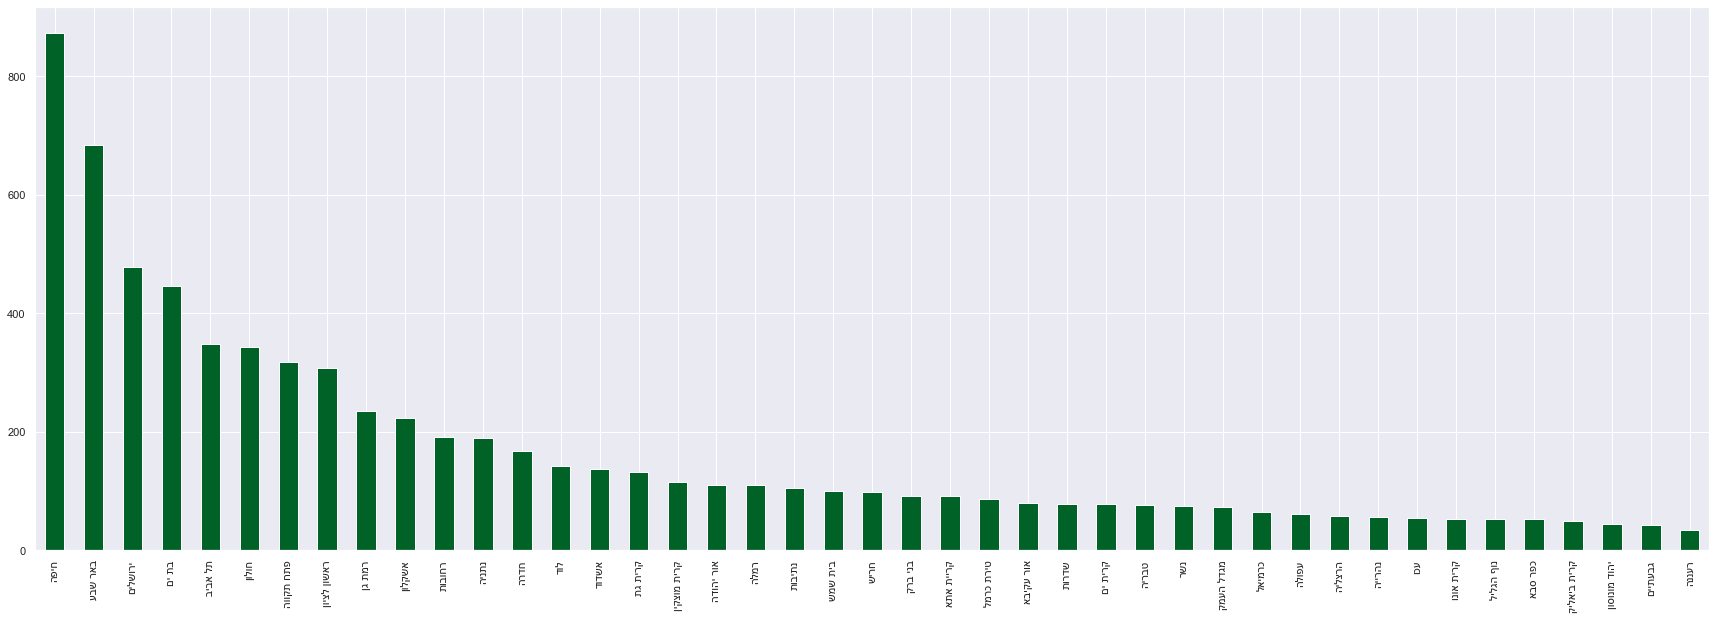

In [24]:
city_count = df['City'].value_counts()
reverse_cities_names = []
for name, value in city_count.items():
    reverse_cities_names.append(name[::-1])
flipped = pd.Series(city_count.values, index=reverse_cities_names)
flipped.plot(kind='bar', figsize=(30,10))

#### Apartment size and price

<AxesSubplot:xlabel='Size', ylabel='Price'>

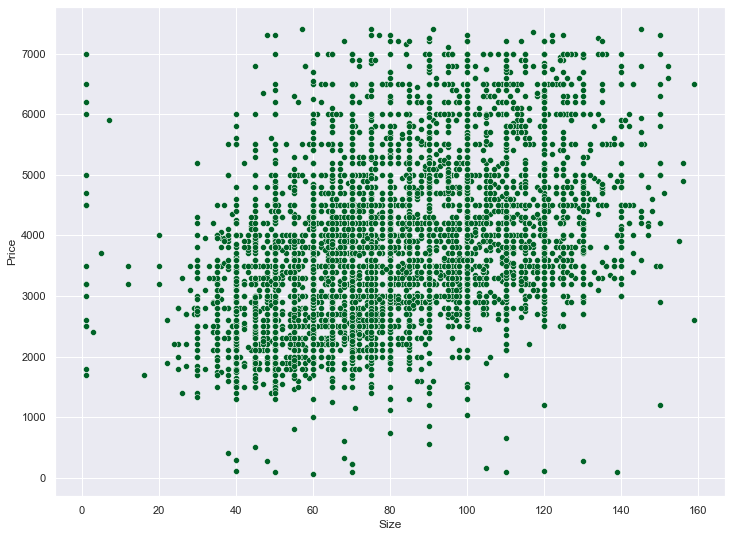

In [25]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)}, palette=sns.color_palette("BuGn_r", 10))
sns.scatterplot(x="Size", y="Price", data=df)

As we can see in the graph, there is a positive correlation between the size of an apartment and it’s price. The bigger the size, the higher the price. This can be also seen through Pearson coefficient, which resulted in a correlation of 0.43 between the two variables. Therefore, we would want to use the Size variable when trying to predict the Price.

In [26]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['Size'], df['Price'])
print('Pearsons correlation for the Size and the Price variables: %.3f' % corr)

Pearsons correlation for the Size and the Price variables: 0.430


#### Binary features

We wanted to see how all the binary features behave and if there is a decent variance.

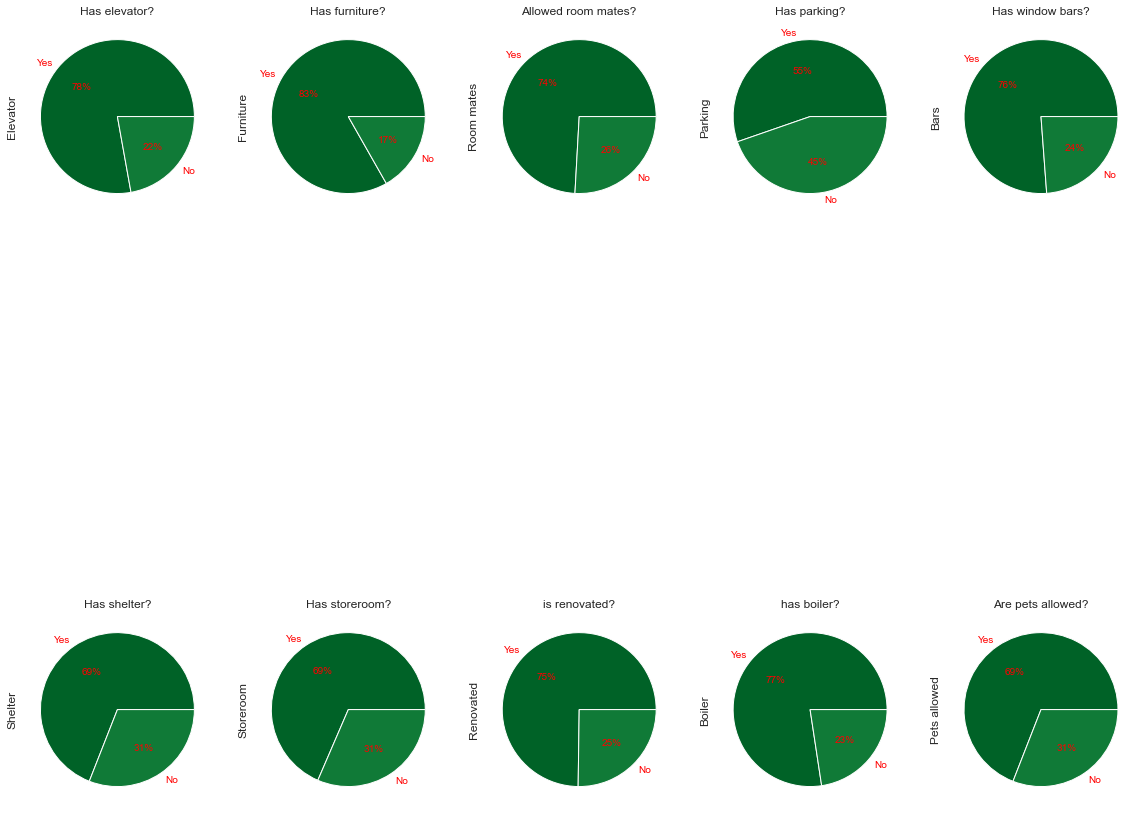

In [87]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5)

df['Elevator'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[0,0], textprops={'color':"red"})
axes[0,0].set_title('Has elevator?', fontsize = 12)
df['Furniture'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[0,1], textprops={'color':"red"})
axes[0,1].set_title('Has furniture?', fontsize = 12)
df['Room mates'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[0,2], textprops={'color':"red"})
axes[0,2].set_title('Allowed room mates?', fontsize = 12)
df['Parking'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[0,3], textprops={'color':"red"})
axes[0,3].set_title('Has parking?', fontsize = 12)
df['Bars'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[0,4], textprops={'color':"red"})
axes[0,4].set_title('Has window bars?', fontsize = 12)
df['Shelter'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[1,0], textprops={'color':"red"})
axes[1,0].set_title('Has shelter?', fontsize = 12)
df['Storeroom'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[1,1], textprops={'color':"red"})
axes[1,1].set_title('Has storeroom?', fontsize = 12)
df['Renovated'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[1,2], textprops={'color':"red"})
axes[1,2].set_title('is renovated?', fontsize = 12)
df['Boiler'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[1,3], textprops={'color':"red"})
axes[1,3].set_title('has boiler?', fontsize = 12)
df['Pets allowed'].value_counts().plot(kind='pie', figsize=(20,20), fontsize=10, labels = ['Yes', 'No'], autopct='%1.0f%%', ax=axes[1,4], textprops={'color':"red"})
axes[1,4].set_title('Are pets allowed?', fontsize = 12)

plt.show()

#### Floor number and elevator

We wanted to see the relation between the floor number and the elevator feature.
The chart represents what percentage of an apartment in floor X has an elevator.

<AxesSubplot:xlabel='Floor number'>

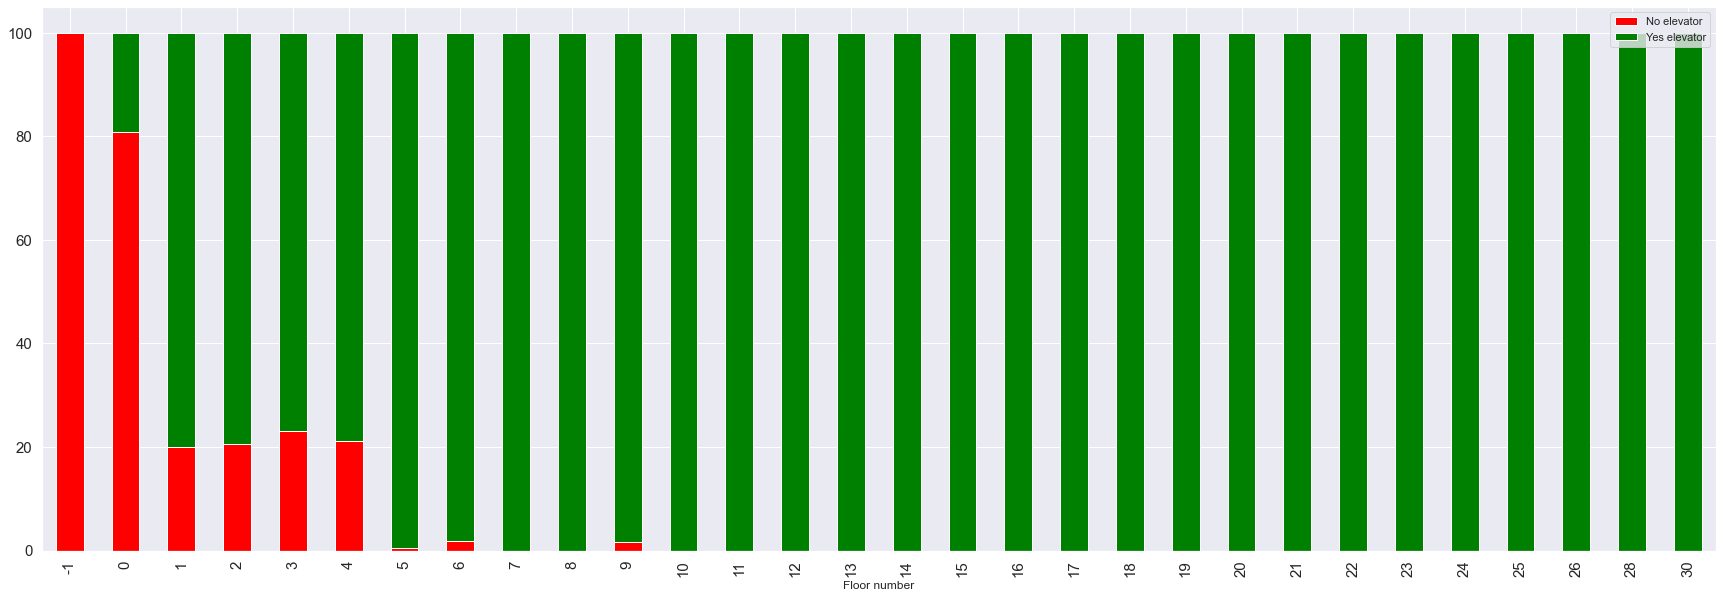

In [139]:
floors = df['Floor number'].value_counts().keys()
floors = sorted(floors)
floors = [int(floor) for floor in floors]

no_elevator, yes_elevator = [], []
for floor_num in floors:
    no = df.loc[(df['Floor number'] == floor_num) & (df['Elevator'] == 0)].shape[0]
    yes = df.loc[(df['Floor number'] == floor_num) & (df['Elevator'] == 1)].shape[0]

    no_elevator.append((no / (no + yes)) * 100)
    yes_elevator.append((yes / (no + yes)) * 100)

#
data = {'Floor number': floors,
        'No elevator': no_elevator,
        'Yes elevator': yes_elevator}

# Convert the dictionary into DataFrame
floor_df = pd.DataFrame(data)
floor_df = floor_df.set_index(floor_df.columns[0])
floor_df.plot(kind='bar', figsize=(30,10), stacked=True, color=['red','green'], fontsize=15)


As we can see in the chart above, the higher the floor, the higher the odds it will have an elevator.

#### Correlation from numeric features to the Price feature

Here we can see the correlation between a few numeric features to our label (Price).
We can notice a slight positive correlation in all of them, but nothing too drastic.

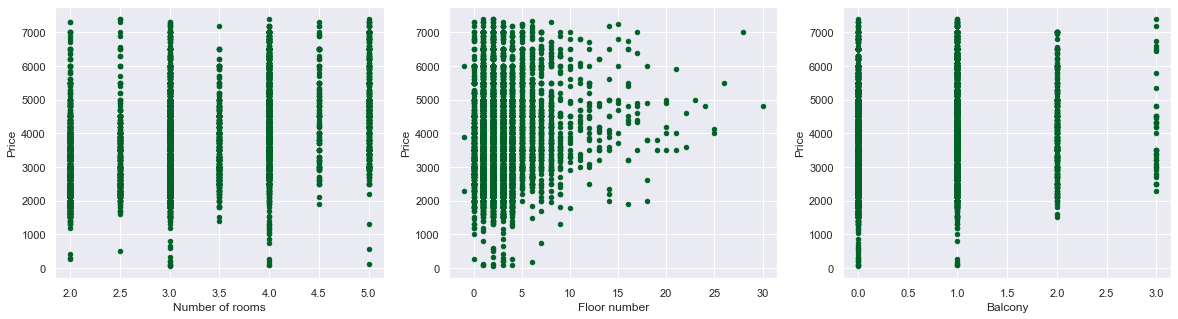

In [161]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

fig, axes=plt.subplots(1, 3)

df.plot(kind='scatter', x='Number of rooms',y='Price', xlabel='Number of rooms', ylabel='Price', ax=axes[0], figsize=(20,5))
df.plot(kind='scatter', x='Floor number',y='Price', xlabel='Floor number', ylabel='Price', ax=axes[1], figsize=(20,5))
df.plot(kind='scatter', x='Balcony',y='Price', xlabel='Balcony', ylabel='Price', ax=axes[2], figsize=(20,5))

plt.show()


# Handling categorical variables

In [25]:
city_score={
    'חיפה': 7,
    'תל אביב': 8,
    'באר שבע': 5,
    'ירושלים': 3,
    'בת ים': 5,
    'פתח תקווה': 7,
    'חולון': 7,
    'רמת גן': 8,
    'ראשון לציון': 7,
    'נתניה': 6,
    'אשקלון': 5,
    'רחובות': 7,
    'חדרה': 6,
    'אשדוד': 4,
    'לוד': 4,
    'קרית גת': 4,
    'קרית מוצקין': 7,
    'רמלה': 4,
    'בני ברק': 2,
    'הרצליה': 8,
    'בית שמש': 2,
    'נתיבות': 3,
    'חריש': 5,
    'קריית אתא': 6,
    'טירת כרמל': 5,
    'קרית ים': 5,
    'טבריה': 4,
    'אור יהודה': 5,
    'נשר': 7,
    'שדרות': 4,
    'אור עקיבא': 5,
    'מגדל העמק': 4,
    'גבעתיים': 9,
    'נהרייה': 6,
    'קרית ביאליק': 7,
    'כרמיאל': 6,
    'קרית אונו': 9,
    'עפולה': 5,
    'עכו': 4,
    'כפר סבא': 8,
    'רעננה': 8,
    'נוף הגליל': 5,
    'יהוד מונוסון': 8
}

To handle categorial variables such as 'City' and 'Neighborhood' We used get_dummies which created a column for each value.

Also, we added another feature to the set. This feature is the city's social rank. This variable goes from 0 to 10, where 10 is the best city to live in. This should reflect on the price of an apartment in that city.

In [26]:
for city_name, value in city_score.items():
    df.loc[df['City'].isin([city_name]), 'City Social Rank'] = value

In [27]:
df.drop(['Neighborhood'], axis=1, inplace=True)

df = pd.get_dummies(df, columns=['City'])
df.head()

,Size,Number of rooms,Floor number,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,...,City_קרית גת,City_קרית ים,City_קרית מוצקין,City_ראשון לציון,City_רחובות,City_רמלה,City_רמת גן,City_רעננה,City_שדרות,City_תל אביב
0,127.0,4.0,5.0,"4,700.0",1,1,1,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,65.0,3.5,1.0,"2,400.0",1,1,1,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,70.0,3.0,1.0,"2,900.0",1,1,1,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,80.0,3.5,3.0,"2,095.0",1,1,1,1,1,0.0,...,0,0,0,0,0,0,0,0,0,0
6,70.0,3.0,1.0,"3,800.0",1,1,1,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0


# Machine learning

#### Scailing

In [28]:
numeric_cols = ['Size', 'Number of rooms', 'Floor number', 'Balcony', 'City Social Rank']
df[numeric_cols] = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)

#### Split label
The 'Price' feature is the one we will want to predict, therefore we would like split it from our dataset

In [29]:
y = df['Price']
X = df.drop(['Price'], axis=1)

#### Train and Test splitting
Splitting the dataframe (85-15), will allow us to train on part of the data and test results on the other part. We use the 'shuffle' argument to mix the 2 data sources (Homeless & Yad2) together

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, shuffle=True)

In [31]:
clf = LinearRegression().fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(y_pred))

           0
0    3,002.9
1    3,288.7
2    3,549.1
3    3,849.4
4    2,575.4
...      ...
1079 4,124.6
1080 2,378.9
1081 3,676.1
1082 4,870.3
1083 3,834.7

[1084 rows x 1 columns]


#### Evaluate
To know how well our model perform, we compare the predicted results with the actual values. To do so, we use r2_score.

In [32]:
from sklearn.metrics import r2_score
accuracy = r2_score(y_test, y_pred)
print(accuracy)

0.7122837190633091
